In [71]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [72]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [73]:
import VAE_tybalt
from VAE_tybalt import VAE

In [74]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [75]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

## Load data

In [87]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [88]:
rnaseq_df.head(5)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.678296,0.289910,0.034230,0.0,0.000000,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
1,0.200633,0.654917,0.181993,0.0,0.000000,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560
2,0.785980,0.140842,0.081082,0.0,0.000000,0.000000,0.000000,0.000000,0.730648,0.657189,...,0.437658,0.471489,0.868774,0.471141,0.487212,0.385521,0.466642,0.784059,0.160797,0.557074
3,0.720258,0.122554,0.180042,0.0,0.000000,0.000000,0.000000,0.000000,0.720306,0.719855,...,0.553306,0.373344,0.818608,0.691962,0.635023,0.430647,0.453690,0.364494,0.161363,0.607895
4,0.767127,0.210393,0.034017,0.0,0.061161,0.000000,0.053021,0.000000,0.739546,0.665684,...,0.601268,0.379943,0.506839,0.684320,0.607821,0.320113,0.476190,0.122722,0.389544,0.698548


### Find genes which have high correlations

In [89]:
# Compute the correlation matrix
corr_matrix = rnaseq_df.corr()

# Find highly correlated columns
threshold = 0.9  # Set the correlation threshold (adjust as needed)
highly_correlated = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated.add(colname_i)
            highly_correlated.add(colname_j)

In [90]:
len(highly_correlated)

276

### Generate a deep copy of the original dataframe

In [91]:
rnaseq_df_noisy = rnaseq_df.copy()

### Add noise to correlated genes (corr > 0.9)

In [131]:
# Creat a dictionary holding data where highest correlated genes are perturbed.
import random

In [93]:
def add_noise_to_n_genes(df, n, corr_genes):
    genes = random.sample(corr_genes, n)
    df_noisy = df.copy()
    noise_std = 0.3
    # Add noise to the selected columns
    for column_name in genes:
        noise = np.random.normal(loc=0, scale=noise_std, size=len(rnaseq_df_noisy))
        df_noisy[column_name] = df_noisy[column_name] + noise

    return df_noisy

In [94]:
num_genes = list(range(1, len(highly_correlated), 10))
noisy_inputs = {
    i: add_noise_to_n_genes(rnaseq_df, i, list(highly_correlated)) for i in num_genes
}

In [95]:
# Set the noise standard deviation
noise_std = 0.3

# Add noise to the selected columns
for column_name in highly_correlated:
    noise = np.random.normal(loc=0, scale=noise_std, size=len(rnaseq_df_noisy))
    rnaseq_df_noisy[column_name] = rnaseq_df_noisy[column_name] + noise

### Check model performace

In [96]:
BCEs = []
for i in noisy_inputs.keys():
    df = noisy_inputs[i]
    recon_batch, latent, _, _, _ = model(torch.tensor(df.values, dtype=torch.float32))
    BCE = model.loss_function_dist(
        recon_batch, torch.tensor(rnaseq_df.values, dtype=torch.float32), latent, 5000
    ).item()
    BCEs.append(BCE)

Text(0, 0.5, 'Binary Cross Entropy')

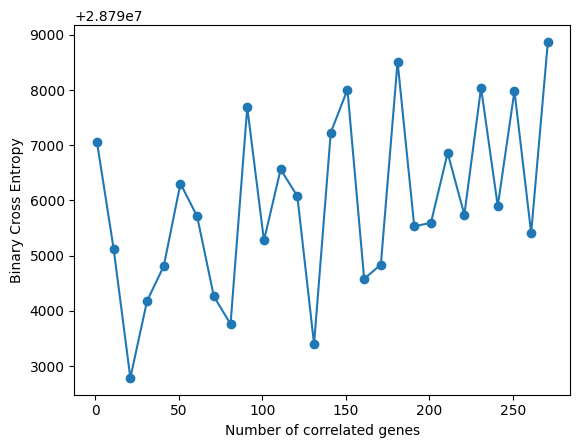

In [97]:
plt.plot(num_genes, BCEs, "-o")
plt.xlabel("Number of correlated genes")
plt.ylabel("Binary Cross Entropy")

In [98]:
filtered_df = corr_matrix.loc[list(highly_correlated), list(highly_correlated)]

### Compute and compare the correlation between genes after reconstruction 

In [99]:
# reconstruct the input dataframe with VAE
def VAE_reconstruct_df(df, model):
    reconstruct_tensor = model.forward(torch.tensor(df.values, dtype=torch.float32))[0]
    dataframe = pd.DataFrame(reconstruct_tensor.detach().numpy(), columns=df.columns)

    return dataframe

In [100]:
noisy_inputs.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271])

### Look at the correlation matrix of reconstructed genes for input genes which are highly correlated

In [101]:
VAE_reconstruct_df(noisy_inputs[1], model)[list(highly_correlated)].corr()

,ZIC1,CYorf15A,ORM1,SLC17A3,CDC6,LGALS7,MCM10,CTAGE4,MAGEA3,COL5A2,...,AHSG,APCS,FCGR2B,NPR3,CKMT1B,ORC1L,IPW,OR2A7,TMEM176A,CDCA5
ZIC1,1.000000,-0.112169,-0.064240,-0.121503,0.048111,-0.049671,0.218892,-0.645835,0.197921,0.011231,...,0.253356,0.114092,-0.179772,-0.393100,-0.154410,0.107503,0.169670,-0.615221,0.035282,0.266155
CYorf15A,-0.112169,1.000000,0.059703,0.076203,-0.171525,-0.051279,-0.174128,-0.138101,0.120308,-0.175816,...,0.099184,0.042600,-0.065330,0.056981,-0.039229,-0.076000,0.148843,-0.109081,-0.000031,-0.109009
ORM1,-0.064240,0.059703,1.000000,0.222544,-0.026821,-0.061067,-0.125763,0.314917,0.107886,0.046075,...,0.760942,0.800383,0.128710,0.155469,-0.206492,-0.088927,-0.174951,0.259321,0.363273,-0.111756
SLC17A3,-0.121503,0.076203,0.222544,1.000000,-0.244298,-0.281890,-0.343960,0.162147,-0.107650,-0.192069,...,0.378976,0.465267,0.087081,0.521984,-0.447188,-0.270412,0.064787,0.056296,0.656624,-0.393050
CDC6,0.048111,-0.171525,-0.026821,-0.244298,1.000000,0.435405,0.922484,0.260251,0.590642,0.414443,...,-0.032475,-0.070875,0.210656,-0.307149,0.126180,0.928440,-0.682322,0.262122,-0.017334,0.904966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ORC1L,0.107503,-0.076000,-0.088927,-0.270412,0.928440,0.470965,0.954461,0.157330,0.541727,0.307248,...,-0.044857,-0.108483,0.217629,-0.306754,0.111934,1.000000,-0.675938,0.175858,-0.025028,0.934437
IPW,0.169670,0.148843,-0.174951,0.064787,-0.682322,-0.423989,-0.629328,-0.357909,-0.353870,-0.360364,...,-0.159909,-0.134619,-0.169127,0.198769,-0.202019,-0.675938,1.000000,-0.349978,-0.204041,-0.659867
OR2A7,-0.615221,-0.109081,0.259321,0.056296,0.262122,0.422988,0.100517,0.943640,0.157648,0.380129,...,-0.006102,0.052630,0.282813,0.361366,0.412495,0.175858,-0.349978,1.000000,0.124555,0.047360
TMEM176A,0.035282,-0.000031,0.363273,0.656624,-0.017334,-0.244962,-0.086617,0.162088,-0.001184,0.280431,...,0.468284,0.559982,0.365226,0.147394,-0.242979,-0.025028,-0.204041,0.124555,1.000000,-0.087597


In [102]:
diff_corr_1 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[1], model)[list(highly_correlated)].corr()
)
diff_corr_101 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[101], model)[list(highly_correlated)].corr()
)
diff_corr_201 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[201], model)[list(highly_correlated)].corr()
)
diff_corr_271 = (
    rnaseq_df[list(highly_correlated)].corr()
    - VAE_reconstruct_df(noisy_inputs[271], model)[list(highly_correlated)].corr()
)

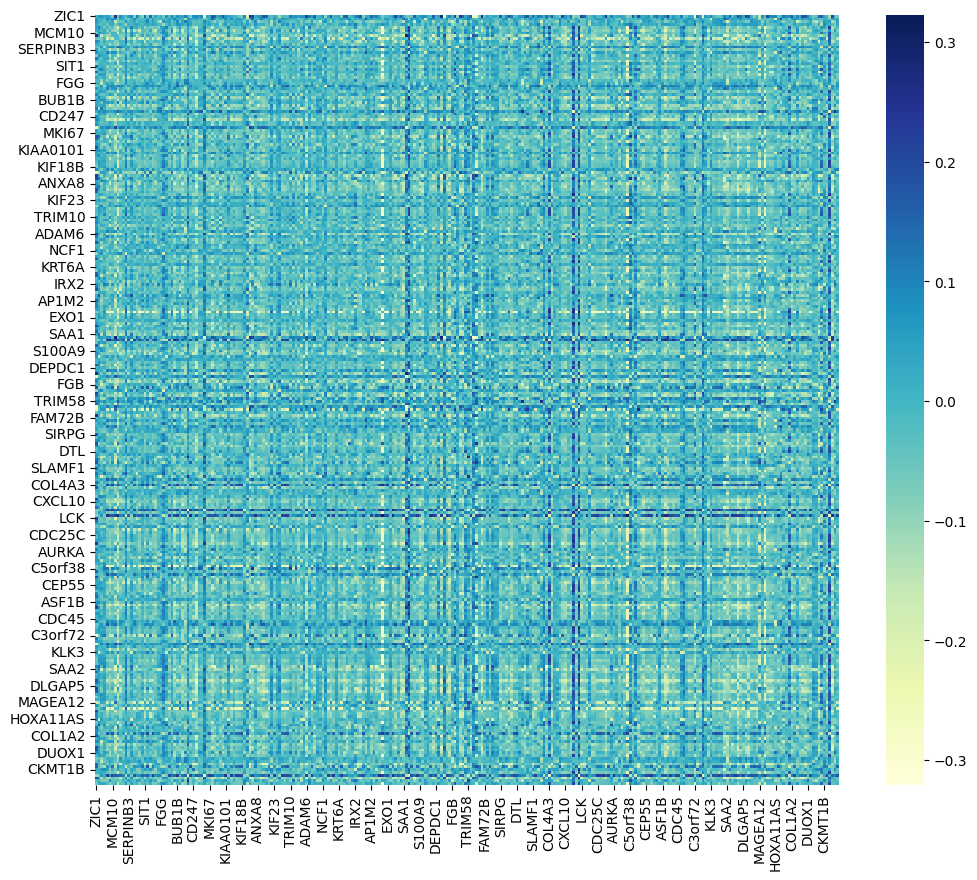

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_1, cmap="YlGnBu")

# Display the plot
plt.show()

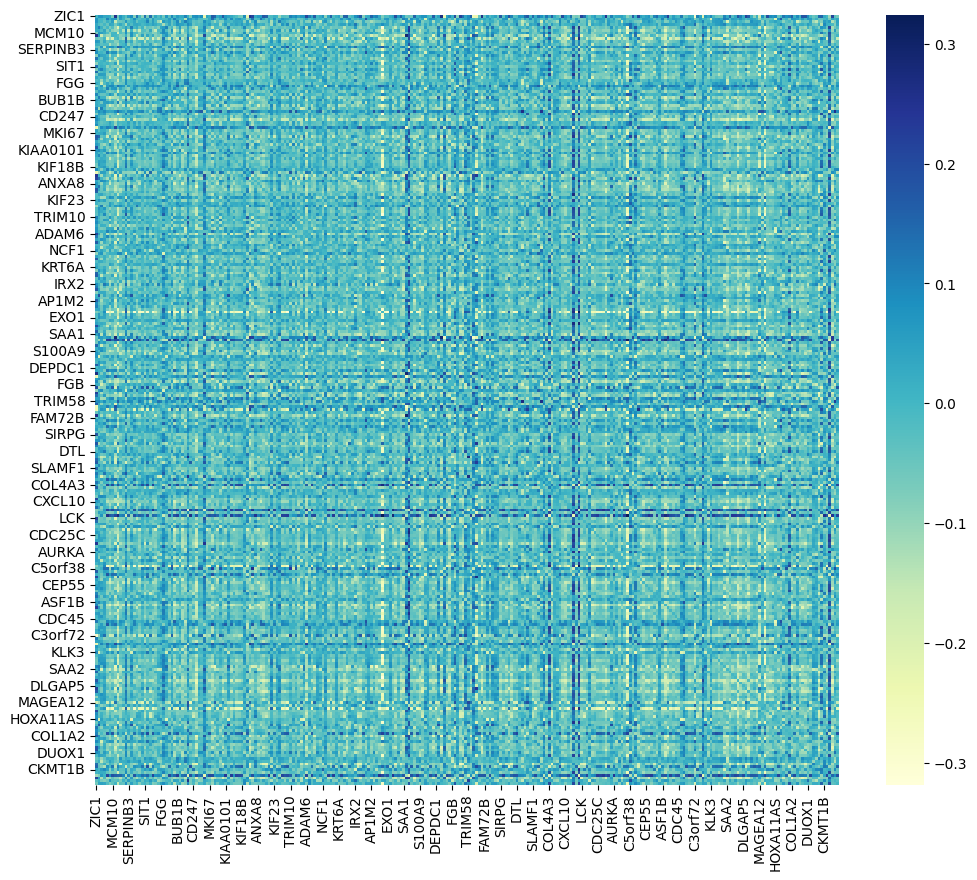

In [104]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_101, cmap="YlGnBu")

# Display the plot
plt.show()

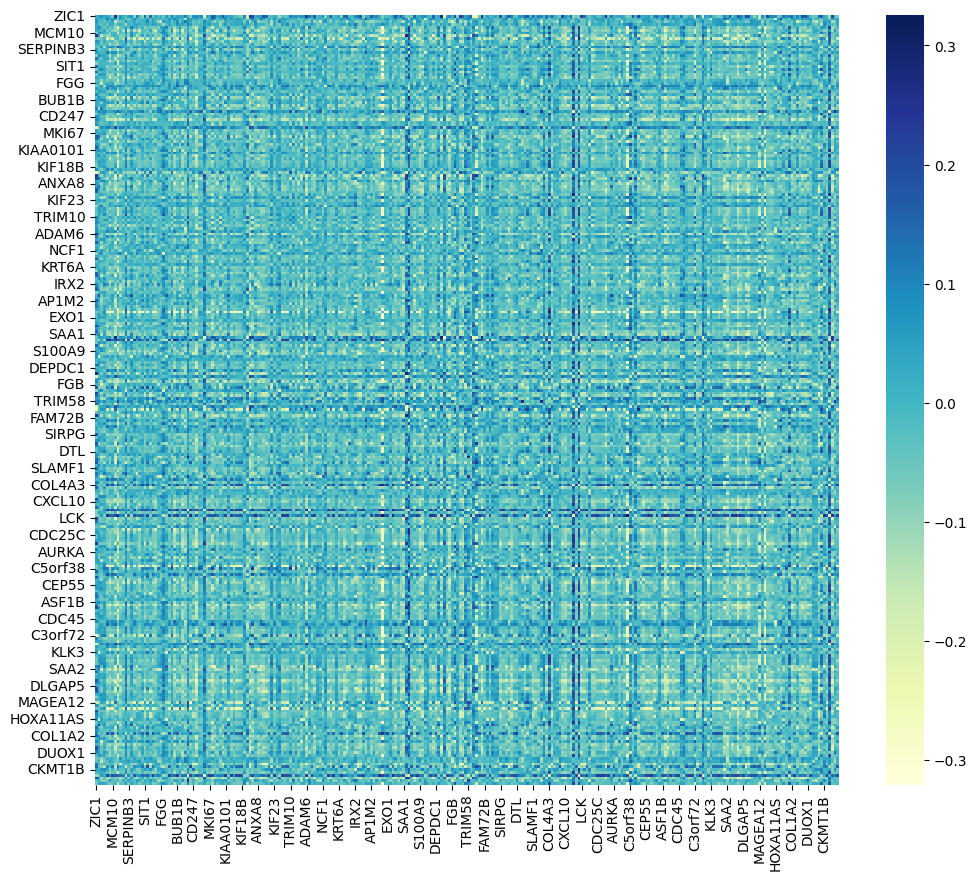

In [105]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_201, cmap="YlGnBu")

# Display the plot
plt.show()

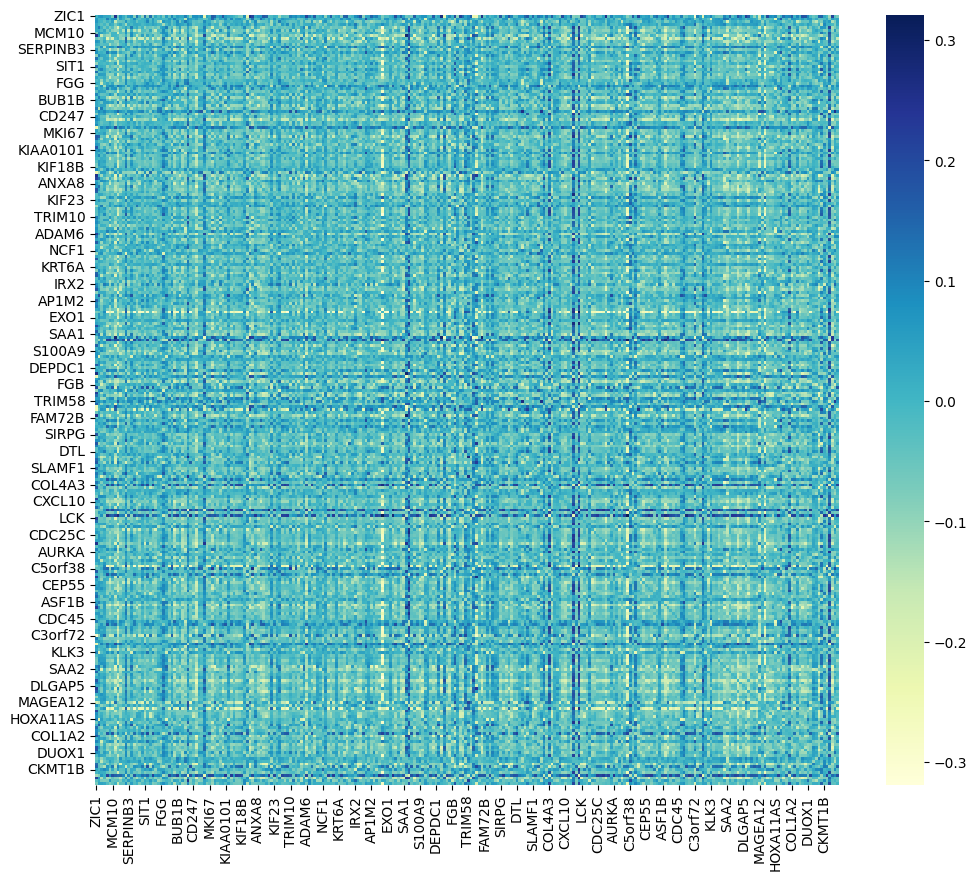

In [106]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(diff_corr_271, cmap="YlGnBu")

# Display the plot
plt.show()

### Perform downstream classification tasks when noise is added to highly correlated genes

In [107]:
# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma

In [185]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)

In [186]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame named 'latent_mu' with the data

# Extract the features from the DataFrame
features = latent_mu.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP().fit_transform(features)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([latent_mu, umap_df], axis=1)

In [188]:
embedded_dataframe = result_df.copy()

In [189]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [190]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [191]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [192]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [193]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

In [194]:
def drop_rows_less_than_n_identical(df, column, n):
    # Count the number of identical values in the specified column
    counts = df[column].value_counts()

    # Get the values that have less than n occurrences
    values_to_drop = counts[counts < n].index.tolist()

    # Drop rows that have values less than n occurrences
    df = df[~df[column].isin(values_to_drop)]

    return df


# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

column_name = "acronym"
n = 2

merged_l_df = drop_rows_less_than_n_identical(merged_l_df, column_name, n)

In [292]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.6360876232671222
F1-score: 0.7288063349497342
Accuracy: 0.9185750636132316
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       1.00      0.95      0.97       160
           2       0.75      0.95      0.84        19
           3       0.84      0.91      0.87        23
           4       0.00      0.00      0.00         1
           5       0.80      1.00      0.89        16
           6       0.00      0.00      0.00         4
           7       0.89      1.00      0.94         8
           8       0.93      0.97      0.95        29
           9       0.95      0.86      0.90        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.71      1.00      0.83        22
          13       0.94      0.91      0.92        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

### Check how highly correlated perturbed gene influence cancer type classification

In [196]:
# Convert classification report to DataFrame
report_data = []
lines = classification_metrics.strip().split("\n")
for line in lines[2:-3]:
    row = line.split()
    report_data.append(row)

classification_metrics_df = pd.DataFrame(
    report_data, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [197]:
classification_metrics_df

,class,precision,recall,f1-score,support
0,0,0.90,0.86,0.88,21
1,1,1.00,0.95,0.97,160
2,2,0.75,0.95,0.84,19
3,3,0.84,0.91,0.87,23
4,4,0.00,0.00,0.00,1
5,5,0.80,1.00,0.89,16
6,6,0.00,0.00,0.00,4
7,7,0.89,1.00,0.94,8
8,8,0.93,0.97,0.95,29
9,9,0.95,0.86,0.90,22


In [198]:
noisy_inputs.keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271])

In [199]:
latent_mu_51, latent_sigma_51 = VAE_latent_out(noisy_inputs[51])

In [200]:
# Extract the features from the DataFrame
features_51 = latent_mu_51.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_51 = umap.UMAP().fit_transform(features_51)

# Create a new DataFrame with UMAP coordinates
umap_df_51 = pd.DataFrame(umap_result_51, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_51 = pd.concat([latent_mu_51, umap_df_51], axis=1)

In [201]:
embedded_dataframe_51 = result_df_51.copy()

In [202]:
embedded_dataframe_51["id"] = df["Unnamed: 0"]

In [203]:
merged_latent_clinical_df_51 = pd.merge(
    clincal_df, embedded_dataframe_51, on="id", how="inner"
)

In [204]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_51 = merged_latent_clinical_df_51.copy()
merged_l_df_51 = merged_l_df_51.dropna()

column_name = "acronym"
n = 2

merged_l_df_51 = drop_rows_less_than_n_identical(merged_l_df_51, column_name, n)

In [205]:
merged_l_df_51["acronym"] = merged_l_df_51["acronym"].astype("category").cat.codes

X_51 = merged_l_df_51[["UMAP1", "UMAP2"]]
y_51 = merged_l_df_51["acronym"]

# Split the data into train and test sets
X_train_51, X_test_51, y_train_51, y_test_51 = train_test_split(
    X_51, y_51, test_size=0.2, random_state=42, stratify=y_51
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_51, y_train_51)

# Make predictions on the test set
y_pred_51 = classifier.predict(X_test_51)

# Compute roc_auc_score
auc_roc_51 = roc_auc_score(
    pd.get_dummies(y_test_51), pd.get_dummies(y_pred_51), average="macro"
)

# Compute F1-score
f1_51 = f1_score(y_test_51, y_pred_51, average="macro")

# Compute accuracy
accuracy_51 = accuracy_score(y_test_51, y_pred_51)

# Compute classification report
classification_metrics_51 = classification_report(y_test_51, y_pred_51)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_51)
print("F1-score:", f1_51)
print("Accuracy:", accuracy_51)
print("Classification Report:\n", classification_metrics_51)

AUC-ROC: 0.6757706686154482
F1-score: 0.7236219644426382
Accuracy: 0.9134860050890585
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.97      0.98      0.98       160
           2       0.75      0.95      0.84        19
           3       0.84      0.91      0.87        23
           4       0.00      0.00      0.00         1
           5       0.76      1.00      0.86        16
           6       0.00      0.00      0.00         4
           7       1.00      1.00      1.00         8
           8       0.83      1.00      0.91        29
           9       0.95      0.82      0.88        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       1.00      0.77      0.87        22
          13       0.94      0.88      0.91        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [206]:
# Convert classification report to DataFrame
report_data_51 = []
lines_51 = classification_metrics_51.strip().split("\n")
for line in lines_51[2:-3]:
    row = line.split()
    report_data_51.append(row)

classification_metrics_df_51 = pd.DataFrame(
    report_data_51, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [207]:
latent_mu_101, latent_sigma_101 = VAE_latent_out(noisy_inputs[101])

In [208]:
# Extract the features from the DataFrame
features_101 = latent_mu_101.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_101 = umap.UMAP().fit_transform(features_101)

# Create a new DataFrame with UMAP coordinates
umap_df_101 = pd.DataFrame(umap_result_101, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_101 = pd.concat([latent_mu_101, umap_df_101], axis=1)

In [209]:
embedded_dataframe_101 = result_df_101.copy()

In [210]:
embedded_dataframe_101["id"] = df["Unnamed: 0"]

In [211]:
merged_latent_clinical_df_101 = pd.merge(
    clincal_df, embedded_dataframe_101, on="id", how="inner"
)

In [212]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_101 = merged_latent_clinical_df_101.copy()
merged_l_df_101 = merged_l_df_101.dropna()

column_name = "acronym"
n = 2

merged_l_df_101 = drop_rows_less_than_n_identical(merged_l_df_101, column_name, n)

In [213]:
merged_l_df_101["acronym"] = merged_l_df_101["acronym"].astype("category").cat.codes

X_101 = merged_l_df_101[["UMAP1", "UMAP2"]]
y_101 = merged_l_df_101["acronym"]

# Split the data into train and test sets
X_train_101, X_test_101, y_train_101, y_test_101 = train_test_split(
    X_101, y_101, test_size=0.2, random_state=42, stratify=y_101
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_101, y_train_101)

# Make predictions on the test set
y_pred_101 = classifier.predict(X_test_101)

# Compute roc_auc_score
auc_roc_101 = roc_auc_score(
    pd.get_dummies(y_test_101), pd.get_dummies(y_pred_101), average="macro"
)

# Compute F1-score
f1_101 = f1_score(y_test_101, y_pred_101, average="macro")

# Compute accuracy
accuracy_101 = accuracy_score(y_test_101, y_pred_101)

# Compute classification report
classification_metrics_101 = classification_report(y_test_101, y_pred_101)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_101)
print("F1-score:", f1_101)
print("Accuracy:", accuracy_101)
print("Classification Report:\n", classification_metrics_101)

AUC-ROC: 0.6518148794434035
F1-score: 0.739850208849959
Accuracy: 0.8854961832061069
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.52      0.59        21
           1       0.95      0.96      0.95       160
           2       0.75      0.95      0.84        19
           3       0.86      0.78      0.82        23
           4       0.00      0.00      0.00         1
           5       0.75      0.94      0.83        16
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         8
           8       0.93      0.93      0.93        29
           9       0.75      0.82      0.78        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.95      0.82      0.88        22
          13       0.94      0.91      0.92        33
          14       0.62      0.89      0.73         9

    accuracy             

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [214]:
# Convert classification report to DataFrame
report_data_101 = []
lines_101 = classification_metrics_101.strip().split("\n")
for line in lines_101[2:-3]:
    row = line.split()
    report_data_101.append(row)

classification_metrics_df_101 = pd.DataFrame(
    report_data_101, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [215]:
latent_mu_151, latent_sigma_151 = VAE_latent_out(noisy_inputs[151])

In [216]:
# Extract the features from the DataFrame
features_151 = latent_mu_151.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_151 = umap.UMAP().fit_transform(features_151)

# Create a new DataFrame with UMAP coordinates
umap_df_151 = pd.DataFrame(umap_result_151, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_151 = pd.concat([latent_mu_151, umap_df_151], axis=1)

In [217]:
embedded_dataframe_151 = result_df_151.copy()

In [218]:
embedded_dataframe_151["id"] = df["Unnamed: 0"]

In [219]:
merged_latent_clinical_df_151 = pd.merge(
    clincal_df, embedded_dataframe_151, on="id", how="inner"
)

In [220]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_151 = merged_latent_clinical_df_151.copy()
merged_l_df_151 = merged_l_df_151.dropna()

column_name = "acronym"
n = 2

merged_l_df_151 = drop_rows_less_than_n_identical(merged_l_df_151, column_name, n)

In [221]:
merged_l_df_151["acronym"] = merged_l_df_151["acronym"].astype("category").cat.codes

X_151 = merged_l_df_151[["UMAP1", "UMAP2"]]
y_151 = merged_l_df_151["acronym"]

# Split the data into train and test sets
X_train_151, X_test_151, y_train_151, y_test_151 = train_test_split(
    X_151, y_151, test_size=0.2, random_state=42, stratify=y_151
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_151, y_train_151)

# Make predictions on the test set
y_pred_151 = classifier.predict(X_test_151)

# Compute roc_auc_score
auc_roc_151 = roc_auc_score(
    pd.get_dummies(y_test_151), pd.get_dummies(y_pred_151), average="macro"
)

# Compute F1-score
f1_151 = f1_score(y_test_151, y_pred_151, average="macro")

# Compute accuracy
accuracy_151 = accuracy_score(y_test_151, y_pred_151)

# Compute classification report
classification_metrics_151 = classification_report(y_test_151, y_pred_151)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_151)
print("F1-score:", f1_151)
print("Accuracy:", accuracy_151)
print("Classification Report:\n", classification_metrics_151)

AUC-ROC: 0.6778206897682286
F1-score: 0.7837136611900529
Accuracy: 0.9185750636132316
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.99      0.98      0.99       160
           2       0.82      0.74      0.78        19
           3       0.81      0.96      0.88        23
           4       0.00      0.00      0.00         1
           5       0.94      0.94      0.94        16
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         8
           8       0.93      0.97      0.95        29
           9       0.95      0.82      0.88        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       1.00      0.82      0.90        22
          13       0.70      0.91      0.79        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [222]:
# Convert classification report to DataFrame
report_data_151 = []
lines_151 = classification_metrics_151.strip().split("\n")
for line in lines_151[2:-3]:
    row = line.split()
    report_data_151.append(row)

classification_metrics_df_151 = pd.DataFrame(
    report_data_151, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [223]:
latent_mu_201, latent_sigma_201 = VAE_latent_out(noisy_inputs[201])

In [224]:
# Extract the features from the DataFrame
features_201 = latent_mu_201.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_201 = umap.UMAP().fit_transform(features_201)

# Create a new DataFrame with UMAP coordinates
umap_df_201 = pd.DataFrame(umap_result_201, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_201 = pd.concat([latent_mu_201, umap_df_201], axis=1)

In [225]:
embedded_dataframe_201 = result_df_201.copy()

In [226]:
embedded_dataframe_201["id"] = df["Unnamed: 0"]

In [227]:
merged_latent_clinical_df_201 = pd.merge(
    clincal_df, embedded_dataframe_201, on="id", how="inner"
)

In [228]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_201 = merged_latent_clinical_df_201.copy()
merged_l_df_201 = merged_l_df_201.dropna()

column_name = "acronym"
n = 2

merged_l_df_201 = drop_rows_less_than_n_identical(merged_l_df_201, column_name, n)

In [229]:
merged_l_df_201["acronym"] = merged_l_df_201["acronym"].astype("category").cat.codes

X_201 = merged_l_df_201[["UMAP1", "UMAP2"]]
y_201 = merged_l_df_201["acronym"]

# Split the data into train and test sets
X_train_201, X_test_201, y_train_201, y_test_201 = train_test_split(
    X_201, y_201, test_size=0.2, random_state=42, stratify=y_201
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_201, y_train_201)

# Make predictions on the test set
y_pred_201 = classifier.predict(X_test_201)

# Compute roc_auc_score
auc_roc_201 = roc_auc_score(
    pd.get_dummies(y_test_201), pd.get_dummies(y_pred_201), average="macro"
)

# Compute F1-score
f1_201 = f1_score(y_test_201, y_pred_201, average="macro")

# Compute accuracy
accuracy_201 = accuracy_score(y_test_201, y_pred_201)

# Compute classification report
classification_metrics_201 = classification_report(y_test_201, y_pred_201)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_201)
print("F1-score:", f1_201)
print("Accuracy:", accuracy_201)
print("Classification Report:\n", classification_metrics_201)

AUC-ROC: 0.7021858597066972
F1-score: 0.781530166752594
Accuracy: 0.910941475826972
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.86      0.77        21
           1       0.99      0.97      0.98       160
           2       0.75      0.95      0.84        19
           3       0.84      0.91      0.87        23
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89        16
           6       0.00      0.00      0.00         4
           7       1.00      0.88      0.93         8
           8       0.93      0.93      0.93        29
           9       0.86      0.82      0.84        22
          10       0.87      0.91      0.89        22
          11       0.00      0.00      0.00         4
          12       0.95      0.82      0.88        22
          13       0.94      0.88      0.91        33
          14       1.00      1.00      1.00         9

    accuracy              

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [230]:
# Convert classification report to DataFrame
report_data_201 = []
lines_201 = classification_metrics_201.strip().split("\n")
for line in lines_201[2:-3]:
    row = line.split()
    report_data_201.append(row)

classification_metrics_df_201 = pd.DataFrame(
    report_data_201, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [231]:
latent_mu_271, latent_sigma_271 = VAE_latent_out(noisy_inputs[271])

In [232]:
# Extract the features from the DataFrame
features_271 = latent_mu_271.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_271 = umap.UMAP().fit_transform(features_271)

# Create a new DataFrame with UMAP coordinates
umap_df_271 = pd.DataFrame(umap_result_271, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_271 = pd.concat([latent_mu_271, umap_df_271], axis=1)

In [233]:
embedded_dataframe_271 = result_df_271.copy()

In [234]:
embedded_dataframe_271["id"] = df["Unnamed: 0"]

In [235]:
merged_latent_clinical_df_271 = pd.merge(
    clincal_df, embedded_dataframe_271, on="id", how="inner"
)

In [236]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df_271 = merged_latent_clinical_df_271.copy()
merged_l_df_271 = merged_l_df_271.dropna()

column_name = "acronym"
n = 2

merged_l_df_271 = drop_rows_less_than_n_identical(merged_l_df_271, column_name, n)

In [237]:
merged_l_df_271["acronym"] = merged_l_df_271["acronym"].astype("category").cat.codes

X_271 = merged_l_df_271[["UMAP1", "UMAP2"]]
y_271 = merged_l_df_271["acronym"]

# Split the data into train and test sets
X_train_271, X_test_271, y_train_271, y_test_271 = train_test_split(
    X_271, y_271, test_size=0.2, random_state=42, stratify=y_271
)

# Initialize and train the classifier
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_271, y_train_271)

# Make predictions on the test set
y_pred_271 = classifier.predict(X_test_271)

# Compute roc_auc_score
auc_roc_271 = roc_auc_score(
    pd.get_dummies(y_test_271), pd.get_dummies(y_pred_271), average="macro"
)

# Compute F1-score
f1_271 = f1_score(y_test_271, y_pred_271, average="macro")

# Compute accuracy
accuracy_271 = accuracy_score(y_test_271, y_pred_271)

# Compute classification report
classification_metrics_271 = classification_report(y_test_271, y_pred_271)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc_271)
print("F1-score:", f1_271)
print("Accuracy:", accuracy_271)
print("Classification Report:\n", classification_metrics_271)

AUC-ROC: 0.6290756543601901
F1-score: 0.8009903849845801
Accuracy: 0.9363867684478372
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90        21
           1       0.97      1.00      0.98       160
           2       0.72      0.95      0.82        19
           3       0.88      0.96      0.92        23
           4       0.00      0.00      0.00         1
           5       1.00      0.94      0.97        16
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         8
           8       0.93      0.97      0.95        29
           9       0.95      0.82      0.88        22
          10       0.90      0.86      0.88        22
          11       0.00      0.00      0.00         4
          12       0.95      0.86      0.90        22
          13       0.94      0.91      0.92        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [240]:
# Convert classification report to DataFrame
report_data_271 = []
lines_271 = classification_metrics_201.strip().split("\n")
for line in lines_271[2:-3]:
    row = line.split()
    report_data_271.append(row)

classification_metrics_df_271 = pd.DataFrame(
    report_data_271, columns=["class", "precision", "recall", "f1-score", "support"]
)

In [244]:
print(classification_metrics_df["f1-score"][0]) 
print(classification_metrics_df_51["f1-score"][0])
print(classification_metrics_df_101["f1-score"][0])
print(classification_metrics_df_151["f1-score"][0])
print(classification_metrics_df_201["f1-score"][0])
print(classification_metrics_df_271["f1-score"][0])

0.88
0.81
0.59
0.84
0.77
0.77


In [252]:
# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

column_name = "acronym"
n = 2

merged_l_df = drop_rows_less_than_n_identical(merged_l_df, column_name, n)

In [255]:
arcronym_dict = {i: list(set(merged_l_df["acronym"]))[i] for i in range(15)}

In [258]:
nosy_genes = [0, 51, 101, 151, 201, 271]

In [295]:
# Avg AUR ROC score
auc_roc_list = [auc_roc, auc_roc_51, auc_roc_101, auc_roc_151, auc_roc_201, auc_roc_271]
f1_list = [f1, f1_51, f1_101, f1_151, f1_201, f1_271]
accuracy_list = [accuracy, accuracy_51, accuracy_101, accuracy_151, accuracy_201, accuracy_271]

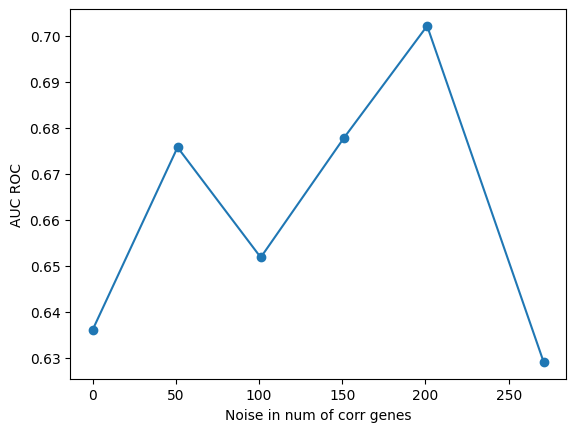

In [296]:
plt.plot(nosy_genes, auc_roc_list, "-o")
plt.ylabel("AUC ROC")
plt.xlabel("Noise in num of corr genes")
plt.show()

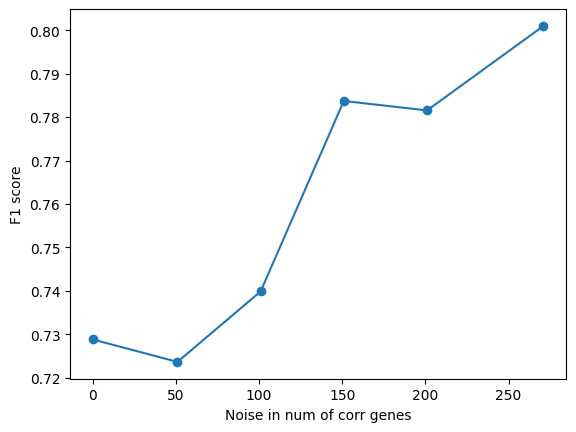

In [297]:
plt.plot(nosy_genes, f1_list, "-o")
plt.ylabel("F1 score")
plt.xlabel("Noise in num of corr genes")
plt.show()

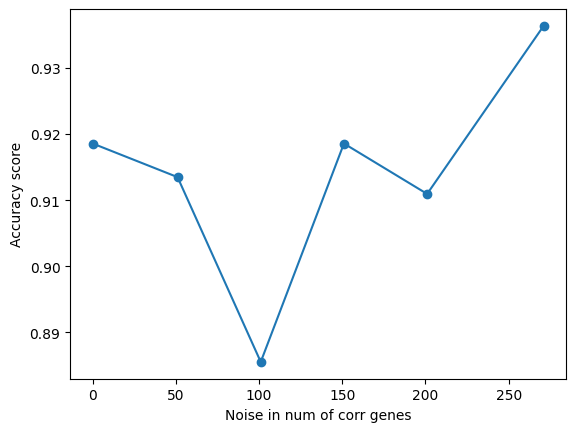

In [298]:
plt.plot(nosy_genes, accuracy_list, "-o")
plt.ylabel("Accuracy score")
plt.xlabel("Noise in num of corr genes")
plt.show()

In [278]:
def plot_f1_score(i):
    f1_score = [
        classification_metrics_df["f1-score"][i],
        classification_metrics_df_51["f1-score"][i],
        classification_metrics_df_101["f1-score"][i],
        classification_metrics_df_151["f1-score"][i],
        classification_metrics_df_201["f1-score"][i],
        classification_metrics_df_271["f1-score"][i],
    ]
    
    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("f1 score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()
    

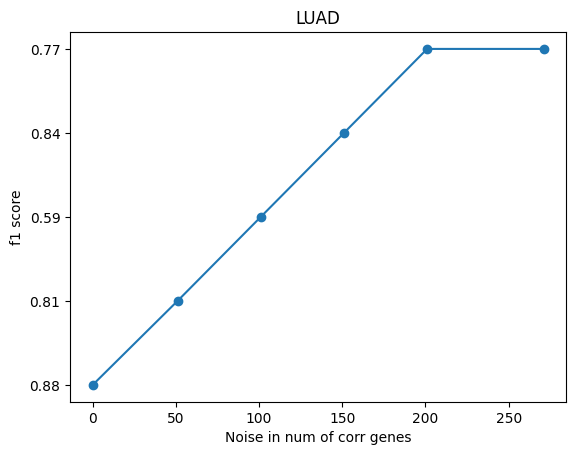

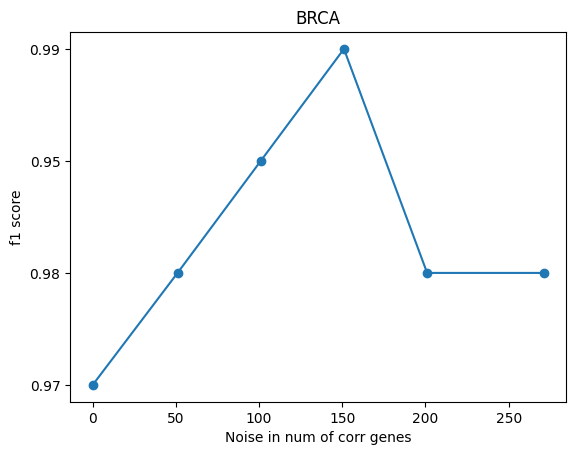

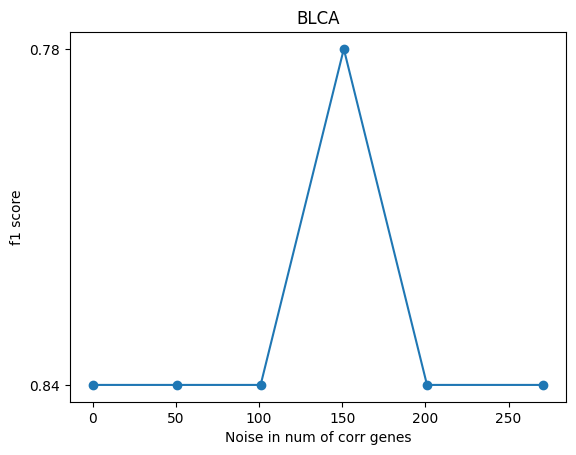

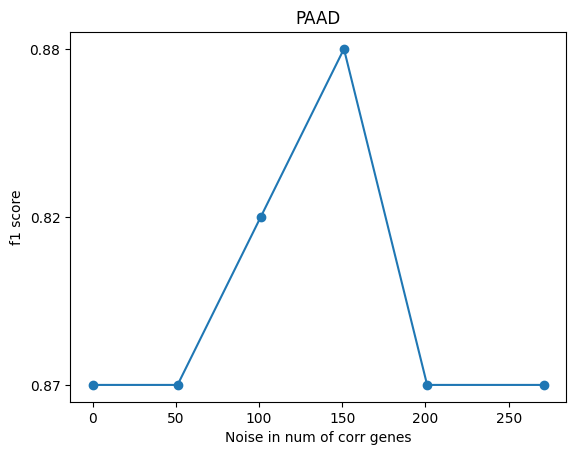

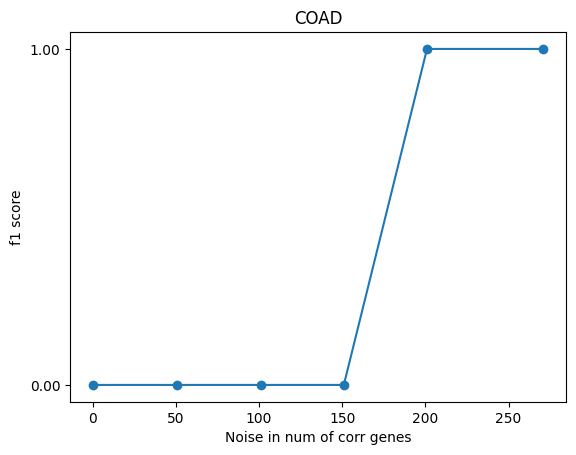

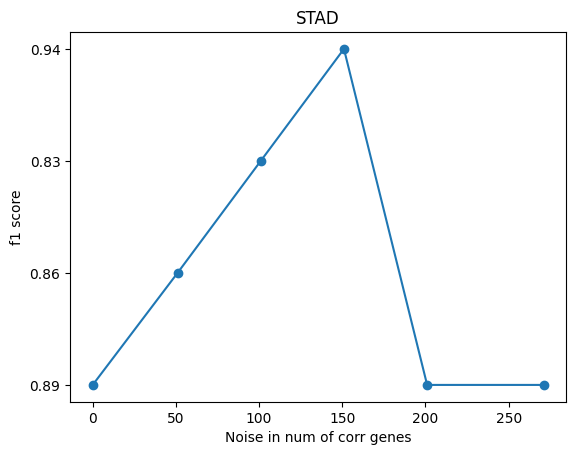

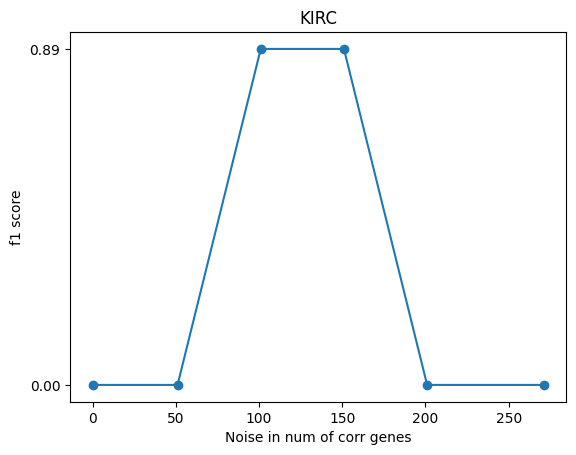

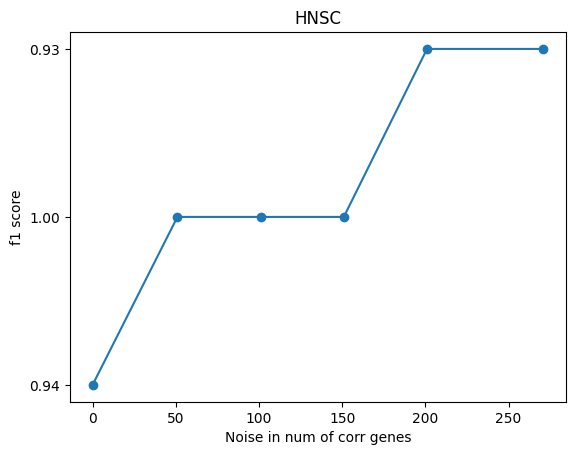

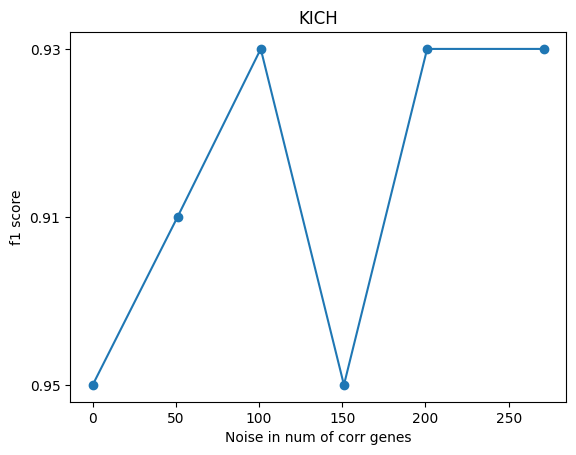

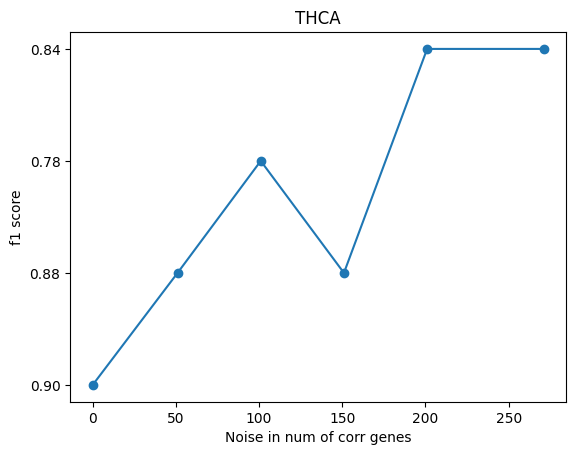

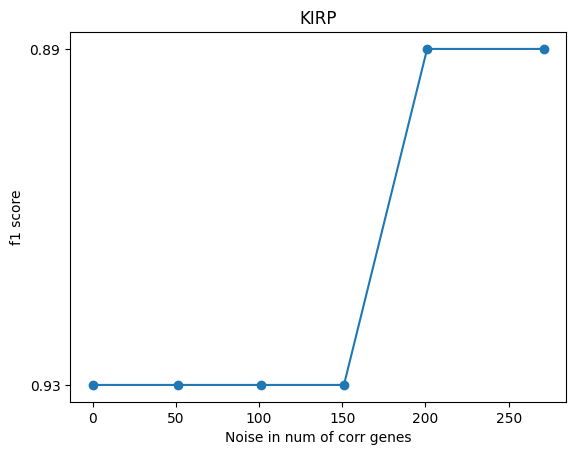

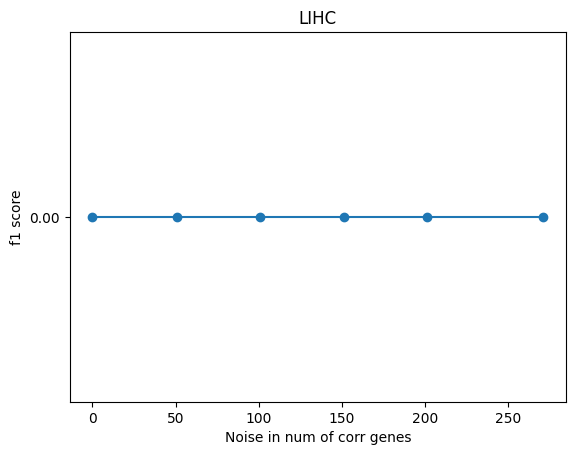

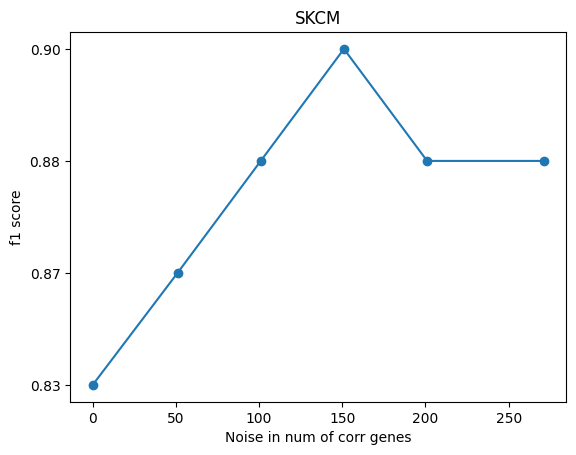

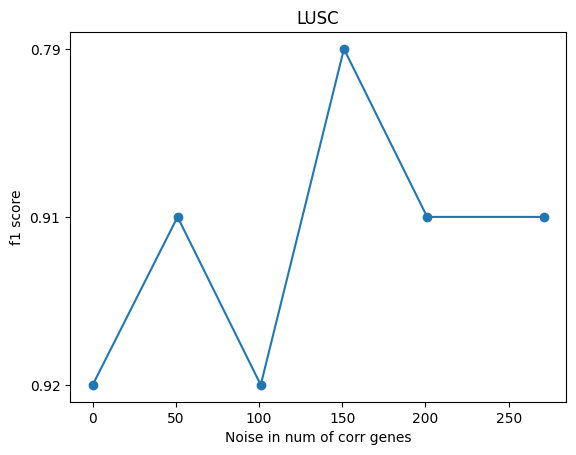

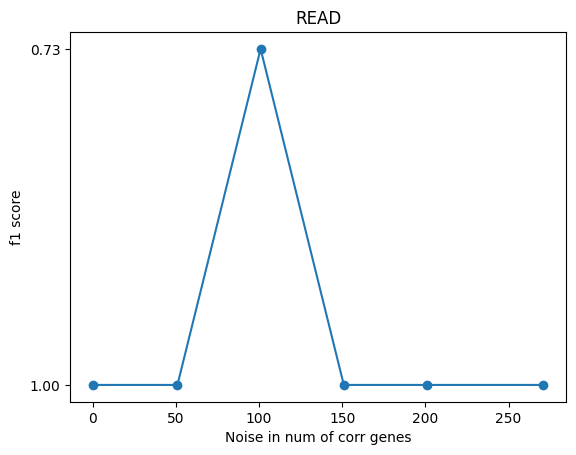

In [282]:
for i in range(15):
    plot_f1_score(i)

In [284]:
def plot_precision_score(i):
    f1_score = [
        classification_metrics_df["precision"][i],
        classification_metrics_df_51["precision"][i],
        classification_metrics_df_101["precision"][i],
        classification_metrics_df_151["precision"][i],
        classification_metrics_df_201["precision"][i],
        classification_metrics_df_271["precision"][i],
    ]
    
    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("precision score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()
    

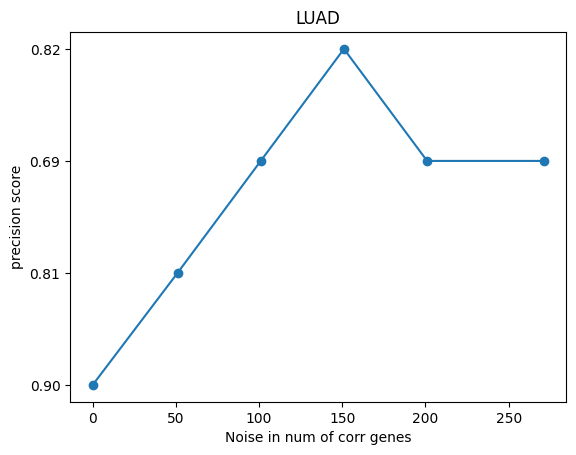

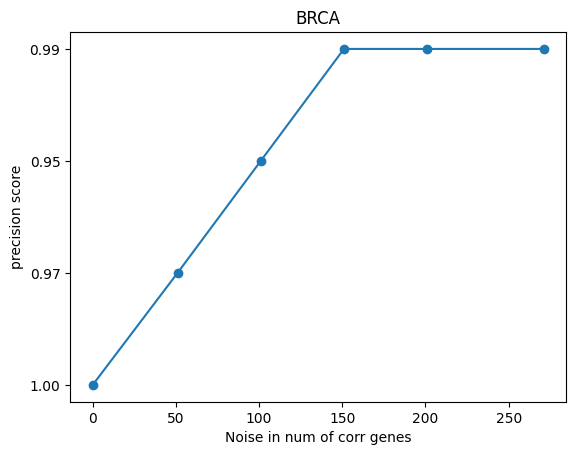

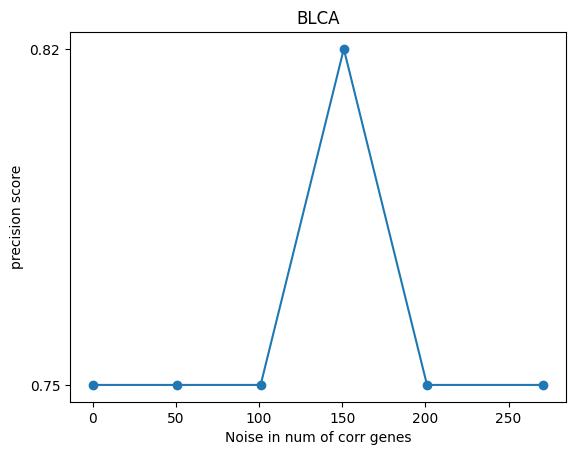

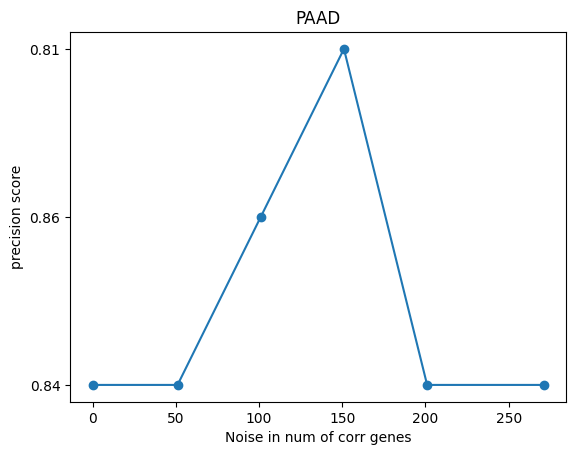

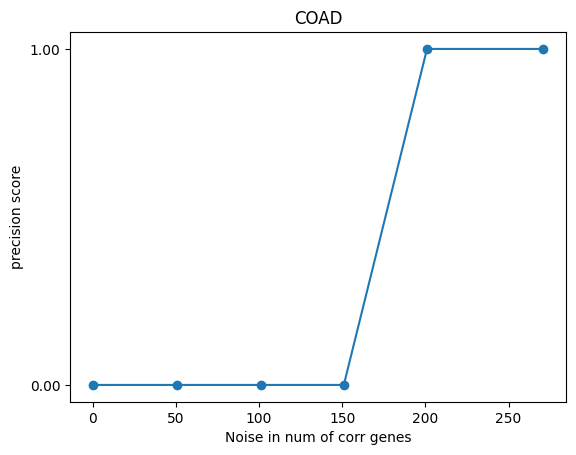

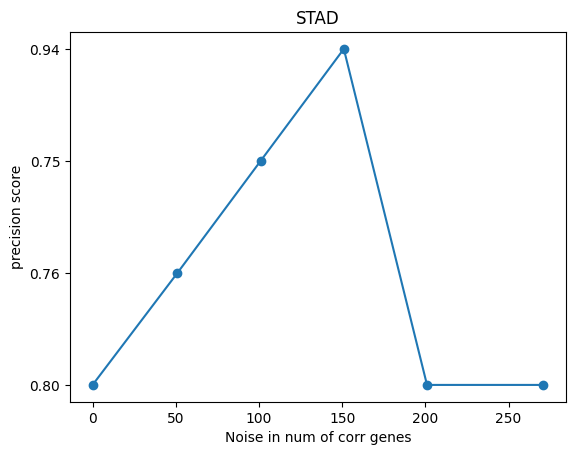

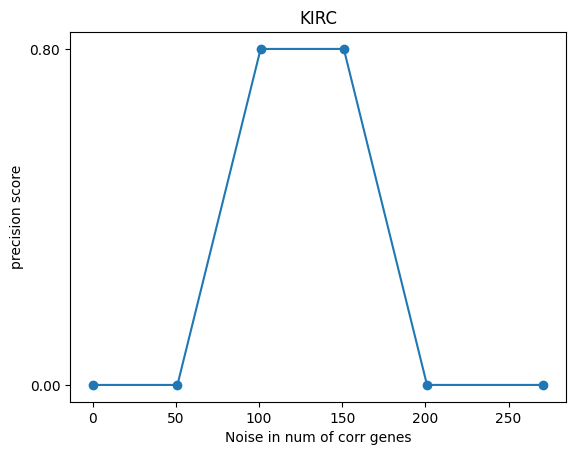

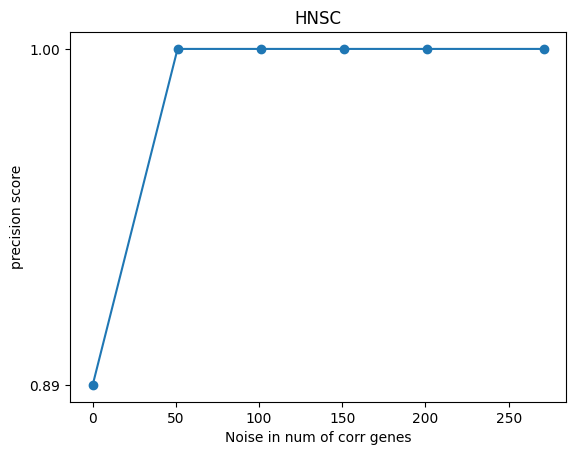

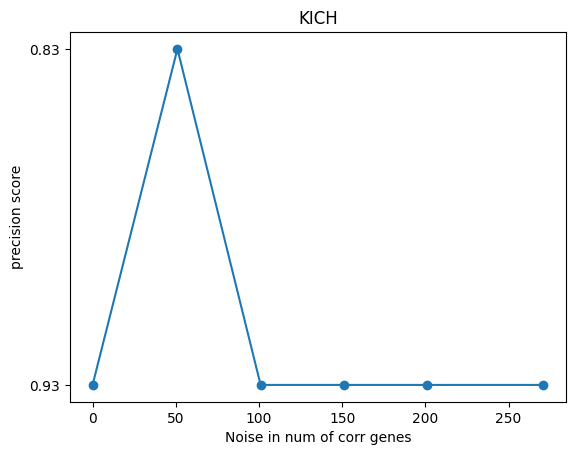

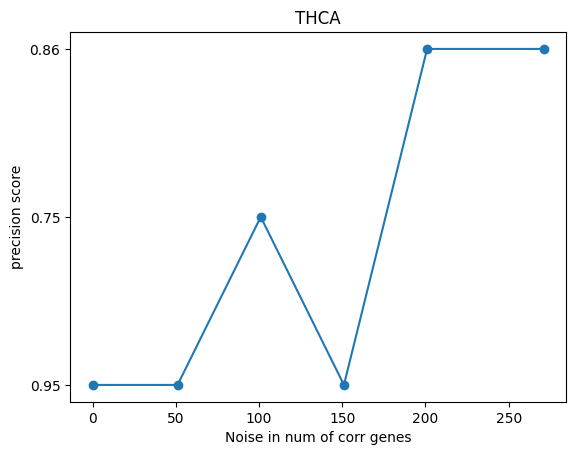

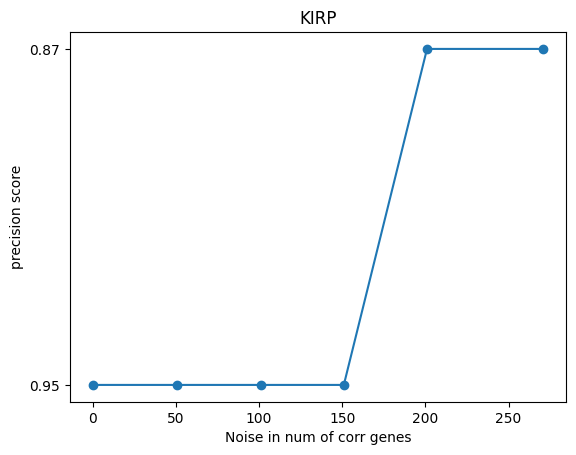

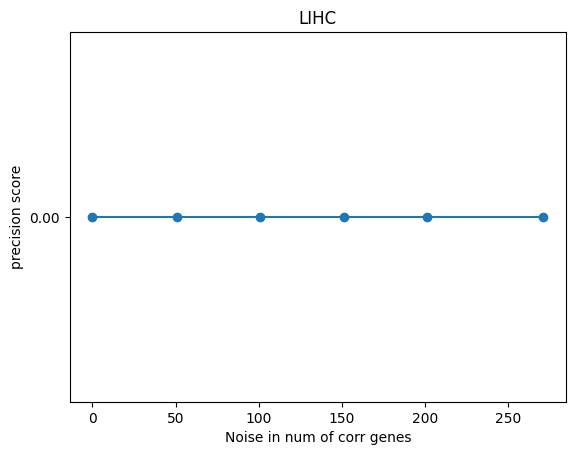

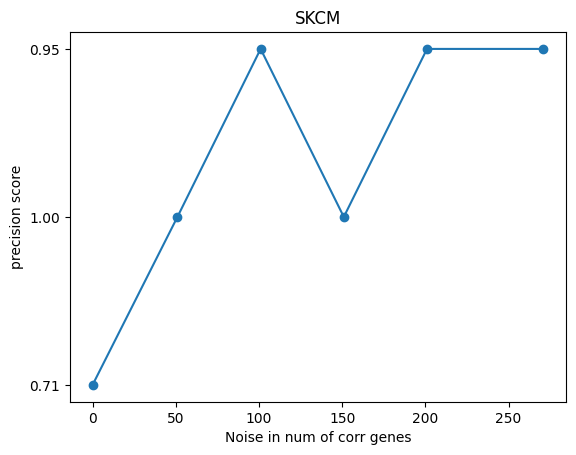

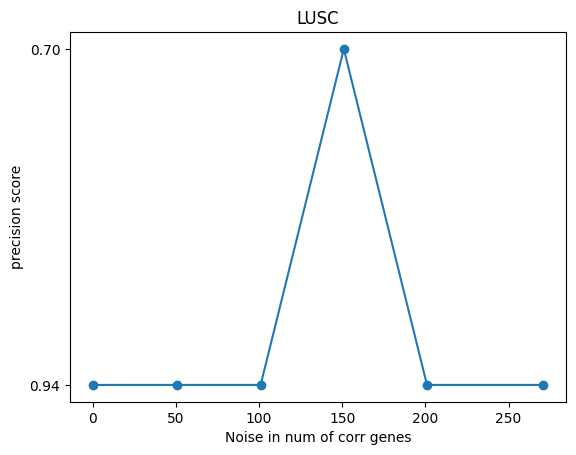

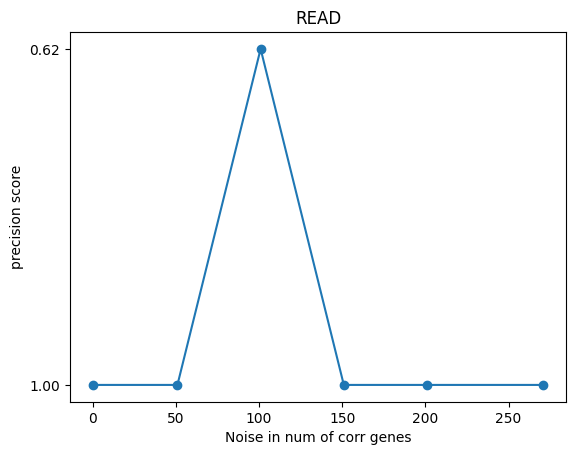

In [285]:
for i in range(15):
    plot_precision_score(i)

In [287]:
def plot_recall_score(i):
    f1_score = [
        classification_metrics_df["recall"][i],
        classification_metrics_df_51["recall"][i],
        classification_metrics_df_101["recall"][i],
        classification_metrics_df_151["recall"][i],
        classification_metrics_df_201["recall"][i],
        classification_metrics_df_271["recall"][i],
    ]
    
    plt.title(arcronym_dict[i])
    plt.plot(nosy_genes, f1_score, "-o")
    plt.ylabel("recall score")
    plt.xlabel("Noise in num of corr genes")
    plt.show()

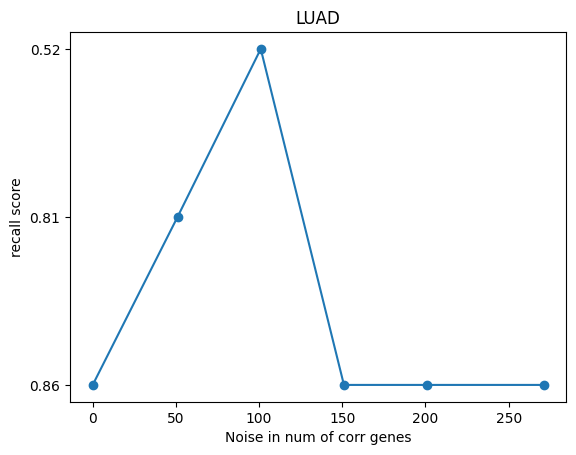

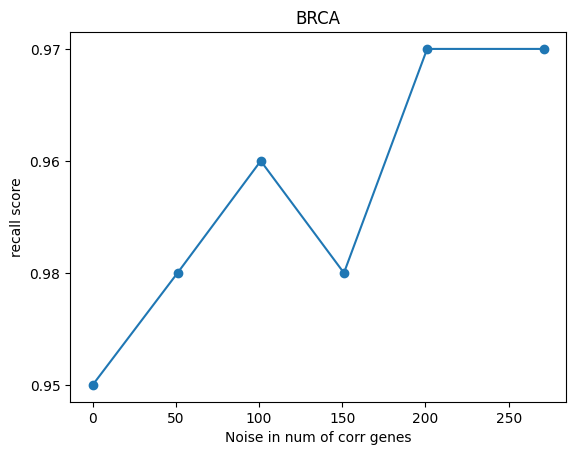

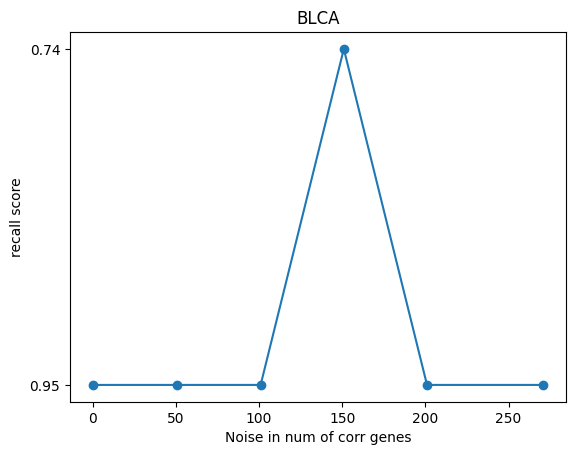

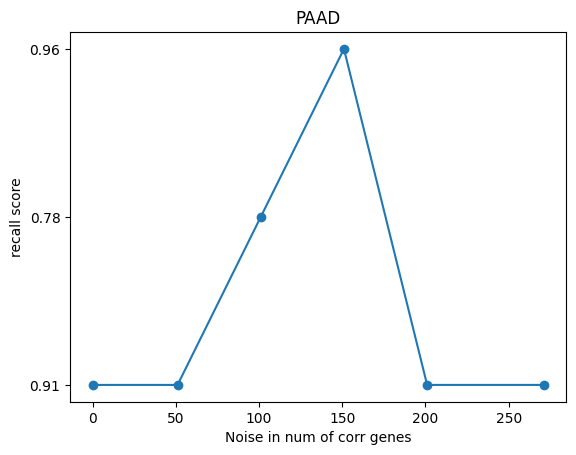

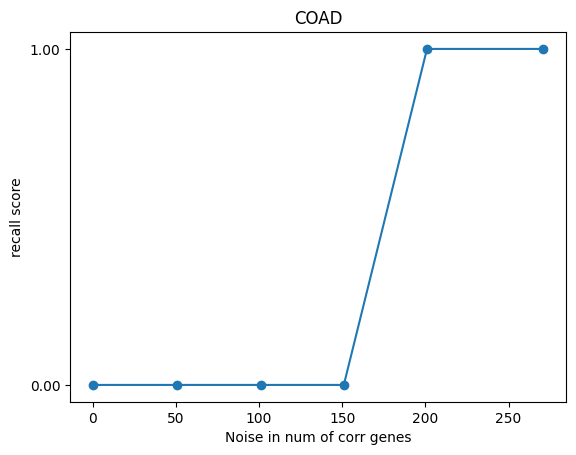

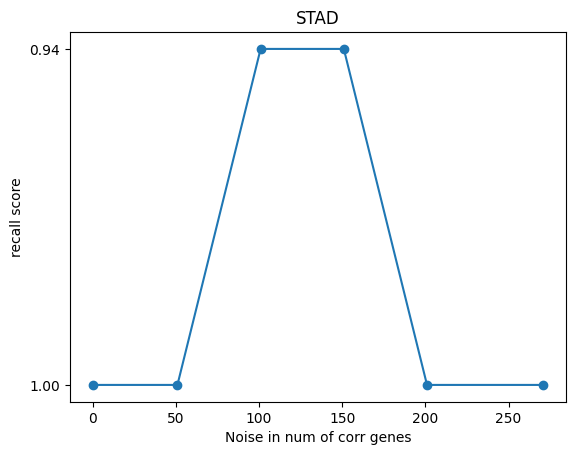

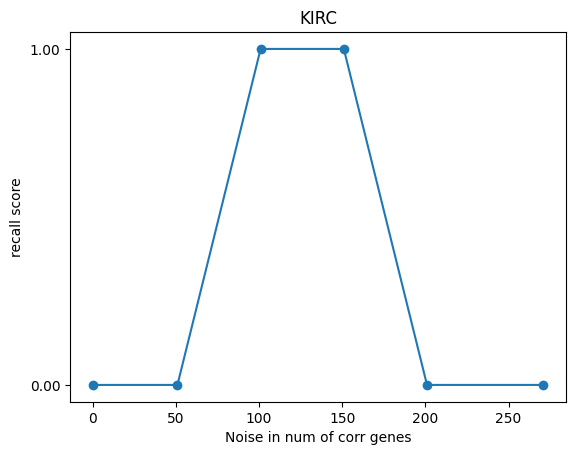

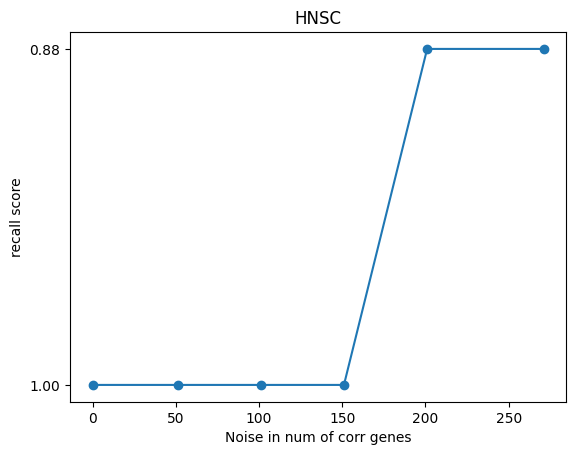

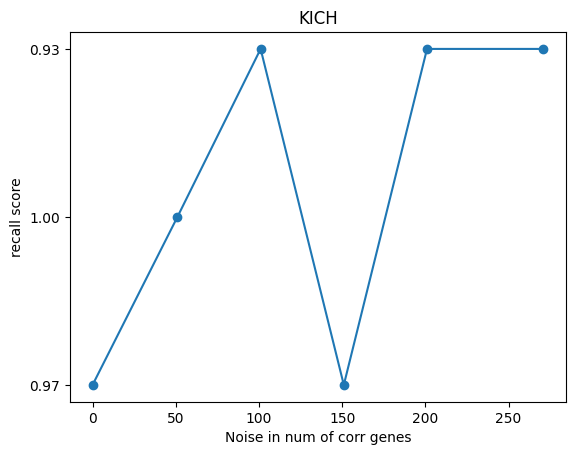

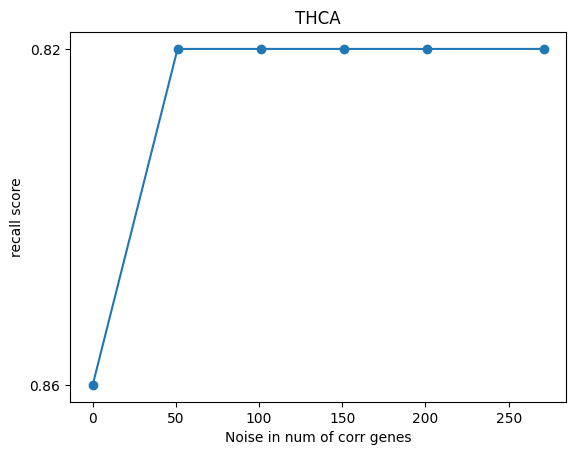

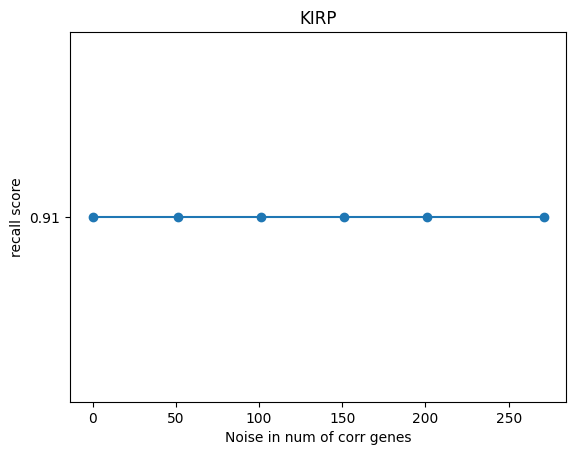

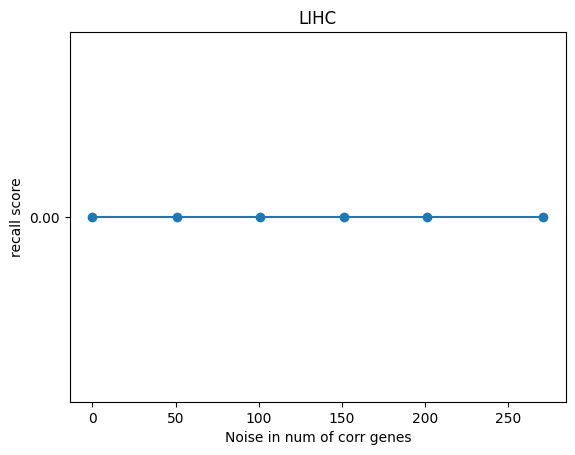

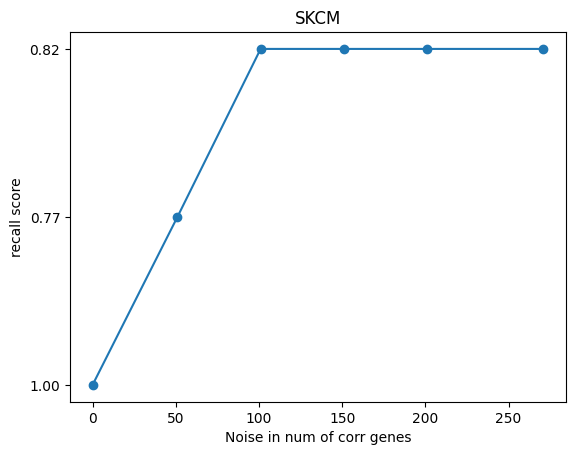

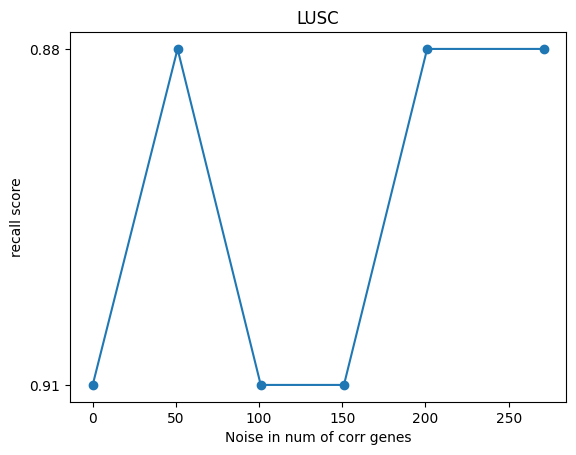

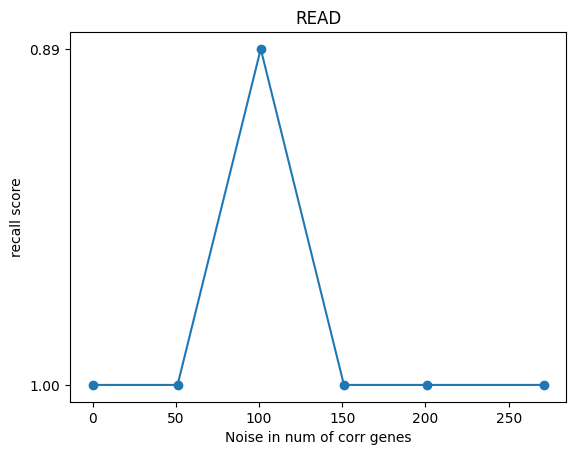

In [288]:
for i in range(15):
    plot_recall_score(i)